In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import os
import matplotlib.pyplot as plt
import numpy as np
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.nn.functional as G

In [2]:
os.listdir('../data/TrainO')

['Scab_Apple', '.DS_Store', 'Normal_Apple', 'Blotch_Apple', 'Rot_Apple']

In [3]:
train_data_path = '../data/TrainO'
test_data_path = '../data/TestO'

In [4]:
training_transforms_formeanstd = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

In [5]:
train_dataset_formeanstd = ImageFolder(root = train_data_path, transform = training_transforms_formeanstd)

In [6]:
train_loader = DataLoader(train_dataset_formeanstd, batch_size=32, shuffle=False)

In [7]:
def get_mean_and_std(loader):
    mean = 0.
    std = 0.
    total_images_count = 0
    
    for images, _ in loader:
        image_count_in_a_batch = images.size(0)
        images = images.view(image_count_in_a_batch, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images_count += image_count_in_a_batch
    
    mean /= total_images_count
    std /=total_images_count
    
    return mean, std

In [8]:
get_mean_and_std(train_loader)

(tensor([0.6524, 0.5119, 0.3597]), tensor([0.2077, 0.2318, 0.2397]))

In [9]:
mean = [0.6524, 0.5119, 0.3597]
std = [0.2077, 0.2318, 0.2397]

train_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
])

test_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
])

In [10]:
train_dataset = ImageFolder(root = train_data_path, transform = train_transforms)
test_dataset = ImageFolder(root = test_data_path, transform = test_transforms)

In [11]:
def show_transformed_images(dataset):
    loader = DataLoader(dataset, batch_size=6, shuffle=True)
    batch = next(iter(loader))
    images, labels = batch
    
    grid = torchvision.utils.make_grid(images, nrow=3)
    plt.figure(figsize=(11,11))
    plt.imshow(np.transpose(grid, (1,2,0)))
    print('labels: ', labels)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


labels:  tensor([0, 3, 0, 0, 2, 2])


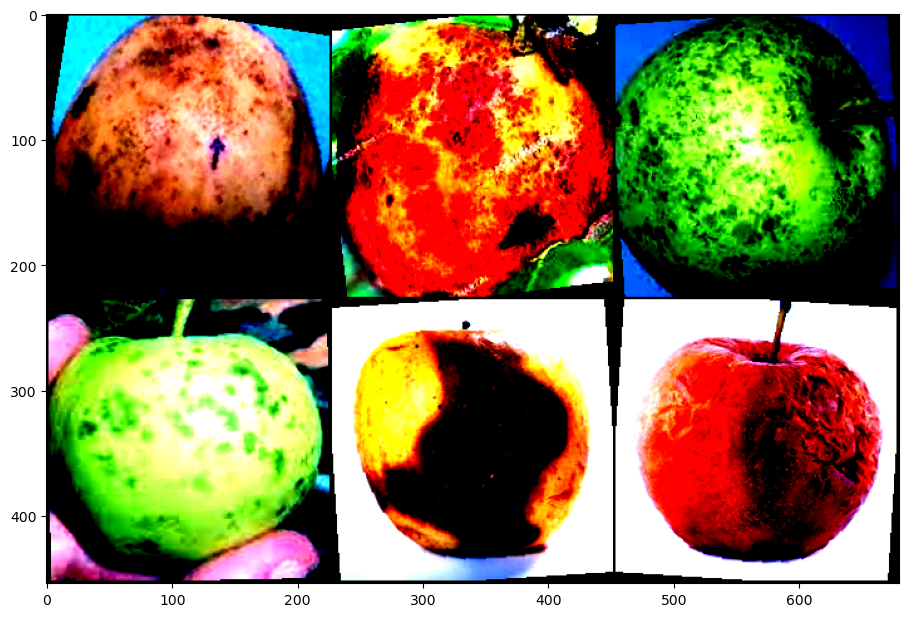

In [12]:
show_transformed_images(train_dataset)

In [13]:
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = 8, shuffle=False)

In [14]:
def set_device():
    if torch.cuda.is_available():
        dev = 'cuda:0'
    else:
        dev = 'cpu'
    return torch.device(dev)

In [25]:
def train_nn(model, train_loader, test_loader, criterion, optimizer, n_epochs):
    device = set_device()

    for epoch in range(n_epochs):
        print(f'Epoch number: {epoch + 1}')
        model.train()
        running_loss = 0.0
        running_correct = 0.0
        total = 0

        for data in train_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            total += labels.size(0)
            
            optimizer.zero_grad()

            outputs = model(images)

            _, predicted = torch.max(outputs.data, 1)

            loss = criterion(outputs, labels)
            loss.backward()

            optimizer.step()

            running_loss += loss.item()
            running_correct += (labels==predicted).sum().item()

        epoch_loss = running_loss/len(train_loader)
        epoch_acc = 100.00 * running_correct / total

        print(f" - Training data. Epoch accuracy is {epoch_acc}. Epoch loss is {epoch_loss}.")

        evaluate_model_on_test(model, test_loader)

        print('Done')

    return model





In [26]:
def evaluate_model_on_test(model, test_loader):
    model.eval()

    pred_correct_in_epoch = 0
    total = 0
    device = set_device()

    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            total += labels.size(0)

            outputs  = model(images)
            _, predicted = torch.max(outputs.data, 1)

            pred_correct_in_epoch += (predicted == labels).sum().item()

    epoch_acc = 100.00 * pred_correct_in_epoch / total
    print(f'Test dataset. Epoch accuracy is {epoch_acc}')

    

In [18]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

resnet18_model = models.resnet18(pretrained=False)
num_features = resnet18_model.fc.in_features
num_of_classes = 4
resnet18_model.fc = nn.Linear(num_features, num_of_classes)
device = set_device()
resnet_18_model = resnet18_model.to(device)
loss_function = nn.CrossEntropyLoss()

optimizer = optim.SGD(resnet18_model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.003)

/Users/danielschene/miniconda3/envs/miw3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/danielschene/miniconda3/envs/miw3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [27]:
train_nn(resnet18_model, train_loader, test_loader, loss_function, optimizer, 10)
    

Epoch number: 1
 - Training data. Epoch accuracy is 41.54302670623145. Epoch loss is 1.6357228457927704.
Test dataset. Epoch accuracy is 39.166666666666664
Done
Epoch number: 2
 - Training data. Epoch accuracy is 46.58753709198813. Epoch loss is 1.918043391271071.
Test dataset. Epoch accuracy is 45.833333333333336
Done
Epoch number: 3
 - Training data. Epoch accuracy is 42.72997032640949. Epoch loss is 2.1463492187586697.
Test dataset. Epoch accuracy is 48.333333333333336
Done
Epoch number: 4
 - Training data. Epoch accuracy is 47.774480712166174. Epoch loss is 1.3636674637144262.
Test dataset. Epoch accuracy is 45.0
Done
Epoch number: 5
 - Training data. Epoch accuracy is 58.160237388724035. Epoch loss is 1.25952301513065.
Test dataset. Epoch accuracy is 53.333333333333336
Done
Epoch number: 6
 - Training data. Epoch accuracy is 59.347181008902076. Epoch loss is 1.056191552769054.
Test dataset. Epoch accuracy is 52.5
Done
Epoch number: 7
 - Training data. Epoch accuracy is 56.97329376

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  